In [ ]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import recall_score

In [ ]:
(trainX, trainy), (testX, testy) = mnist.load_data()  # загрузка данных
# стандартизация
trainX = trainX / 255  # 255 черный
testX = testX / 255

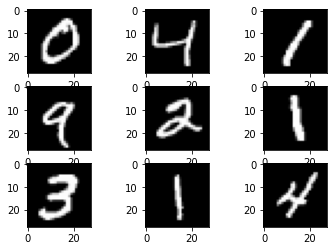

In [ ]:
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
 
# Display the entire plot
plt.show()

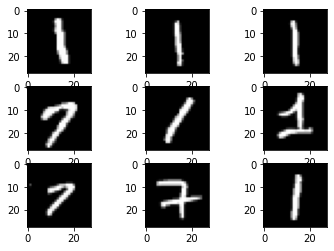

In [ ]:
def getTrainData():
  x_data_train = []
  y_data_train = []
  for i in range(len(trainX)):
    if(trainy[i] == 1 or trainy[i] == 7):
      x_data_train.append(trainX[i])
      y_data_train.append(trainy[i])

  return np.array(x_data_train), np.array(y_data_train)

def getTestData():
  x_data_test = []
  y_data_test = []
  for i in range(len(testX)):
    if(testy[i] == 1 or testy[i] == 7):
      x_data_test.append(testX[i])
      y_data_test.append(testy[i])
  
  return np.array(x_data_test), np.array(y_data_test)

x_train, y_train = getTrainData()
x_test, y_test = getTestData()

for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))

plt.show()


In [ ]:
from sklearn.decomposition import PCA

nsamples, nx, ny = x_train.shape
x_train = x_train.reshape((nsamples,nx*ny))

# pca = PCA(n_components=2)
# X_reduced = pca.fit_transform(x_train)

# plt.figure(figsize=(12,10))
# plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, 
#            edgecolor='green', alpha=0.7, s=40,
#            cmap=plt.cm.get_cmap('nipy_spectral', 10))
# plt.colorbar()

In [ ]:
print(x_train[0].shape)

(784,)


soft margin SVM

In [ ]:
def add_bias_feature(a):  #расширение векторов
    a_extended = np.zeros((a.shape[0],a.shape[1]+1))
    a_extended[:,:-1] = a
    a_extended[:,-1] = int(1)  
    return a_extended

class SVM(object):

    #__class__ = "CustomSVM"
    #__doc__ = ""

    def __init__(self, etha=0.01, alpha=0.1, epochs=200):  # инициализатор, _etha – шаг градиентного спуска _alpha – коэффициент быстроты пропорционального уменьшения весов (перед квадратичным слагаемым в функции потерь), _epochs – количество эпох обучения
        self._epochs = epochs
        self._etha = etha
        self._alpha = alpha
        self._w = None
        self.history_w = []
        self.train_errors = None
        self.val_errors = None
        self.train_loss = None
        self.val_loss = None

    def fit(self, X_train, Y_train, X_val, Y_val, verbose=False): #arrays: X; Y =-1,1 обучение

        if len(set(Y_train)) != 2 or len(set(Y_val)) != 2:
            raise ValueError("Number of classes in Y is not equal 2!")

        X_train = add_bias_feature(X_train)
        X_val = add_bias_feature(X_val)
        self._w = np.random.normal(loc=0, scale=0.05, size=X_train.shape[1])
        self.history_w.append(self._w)
        train_errors = []
        val_errors = []
        train_loss_epoch = []
        val_loss_epoch = []

        for epoch in range(self._epochs): 
            tr_err = 0
            val_err = 0
            tr_loss = 0
            val_loss = 0
            for i,x in enumerate(X_train):
                margin = Y_train[i]*np.dot(self._w,X_train[i])
                if margin >= 1: # классифицируем верно
                    self._w = self._w - self._etha*self._alpha*self._w/self._epochs
                    tr_loss += self.soft_margin_loss(X_train[i],Y_train[i])
                else: # классифицируем неверно или попадаем на полосу разделения при 0<m<1
                    self._w = self._w +\
                    self._etha*(Y_train[i]*X_train[i] - self._alpha*self._w/self._epochs)
                    tr_err += 1
                    tr_loss += self.soft_margin_loss(X_train[i],Y_train[i])
                self.history_w.append(self._w)
            for i,x in enumerate(X_val):
                val_loss += self.soft_margin_loss(X_val[i], Y_val[i])
                val_err += (Y_val[i]*np.dot(self._w,X_val[i])<1).astype(int)
            if verbose:
                print("epoch {}. Errors={}. Mean Hinge_loss={}"\
                      .format(epoch,err,loss))
            train_errors.append(tr_err)
            val_errors.append(val_err)
            train_loss_epoch.append(tr_loss)
            val_loss_epoch.append(val_loss)
        self.history_w = np.array(self.history_w)    
        self.train_errors = np.array(train_errors)
        self.val_errors = np.array(val_errors)
        self.train_loss = np.array(train_loss_epoch)
        self.val_loss = np.array(val_loss_epoch)                    

    def predict(self, X:np.array) -> np.array:   # предсказания
        y_pred = []
        X_extended = add_bias_feature(X)
        for i in range(len(X_extended)):
            y_pred.append(np.sign(np.dot(self._w,X_extended[i])))
        return np.array(y_pred)         

    def hinge_loss(self, x, y):   # нахождение лосс функции
        return max(0,1 - y*np.dot(x, self._w))

    def soft_margin_loss(self, x, y):  # нахождения общей лосс функции классического алгоритма с мягким зазором
        return self.hinge_loss(x,y)+self._alpha*np.dot(self._w, self._w)

In [ ]:
C = 1.0 #Regularization parameter
model1 = SVC(kernel='linear', C=C)
nsamples, nx, ny = x_test.shape
x_test = x_test.reshape((nsamples,nx*ny))

model1.fit(x_train, y_train) #Fit the SVM model according to the given training data
y_predict = model1.predict(x_test) #Perform classification on samples in X
print(recall_score(y_test, y_predict, average=None)) #В случае многоклассовой классификации это определяет тип усреднения данных.

[0.99735683 0.98638132]


Точность

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_predict))

Accuracy: 0.9921405455386038


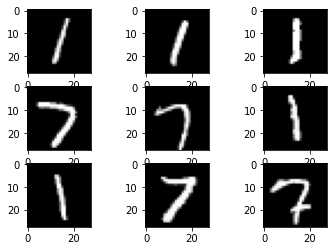

In [ ]:
new_test_x, new_test_y = getTestData()

for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(new_test_x[i], cmap=plt.get_cmap('gray'))

plt.show()

In [ ]:
for i in range(1, 10):
  message = 'One' if y_predict[i] == 1 else 'Seven'
  print(message + ' ' + str(y_predict[i]))

One 1
One 1
One 1
Seven 7
Seven 7
One 1
One 1
Seven 7
Seven 7
